In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [42]:
config={
    'batch_size':2,
    'epochs':4,
    'lr':0.0001,
    'verbose':100,
}

In [79]:
class HandWriteStyle(Dataset):
    def __init__(self,image_folder):
        self.image_path=[image_folder+'/'+x for x in os.listdir(image_folder)]
        self.len=len(self.image_path)
    def __len__(self):
        return self.len
    def __getitem__(self, item):
        image=cv2.imread(self.image_path[item]).astype(np.float32)/255.0
        return torch.tensor(image).permute(2,0,1).view(3,256,256)
    def plot_image(self,index):
        print('This is the picture',index)
        image=cv2.imread(self.image_path[index])
        plt.imshow(image)

In [80]:
styleDataset=HandWriteStyle('./letter-style')
dataloader=DataLoader(styleDataset,batch_size=config['batch_size'],shuffle=True)

In [81]:
def plt_progress(data):
    df=pd.DataFrame(data,columns=['loss'])
    df.plot(ylim=(0),figsize=(16,8),alpha=0.5,marker='.',grid=True,yticks=[0,0.25,0.5,1.0,5.0])

In [82]:
class View(nn.Module):
    def __init__(self,shape):
        super(View, self).__init__()
        self.shape=shape
    def forward(self,x):
        return x.view(self.shape)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model=nn.Sequential(
            nn.Conv2d(3,256,kernel_size=8,stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256,256,kernel_size=8,stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(1),
            nn.Linear(256,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.model(x)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        d=27
        self.model=nn.Sequential(
            nn.Linear(100,3*d*d),
            nn.LeakyReLU(0.2),
            View((-1,3,d,d)),
            nn.ConvTranspose2d(3,256,kernel_size=8,stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256,256,kernel_size=8,stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256,3,kernel_size=8,stride=2,padding=1),
            nn.BatchNorm2d(3),
            nn.Sigmoid()
        )
    def forward(self):
        x=torch.randn([config['batch_size'],100]).to(device)
        return self.model(x)

In [83]:
def train_one_step(D,G,image,loss_fun,optim_D,optim_G):
    real_label=torch.ones([config['batch_size'],1]).to(device)
    fake_label=torch.zeros([config['batch_size'],1]).to(device)
    # 1
    loss_d=loss_fun(D(image),real_label)
    loss_d.backward()
    optim_D.step()
    optim_D.zero_grad()
    loss1=loss_d.item()
    # 2
    loss_d=loss_fun(D(G().detach()),fake_label)
    loss_d.backward()
    optim_D.step()
    optim_D.zero_grad()
    loss2=loss_d.item()
    # 3
    loss_g=loss_fun(D(G()),real_label)
    loss_g.backward()
    optim_G.step()
    optim_G.zero_grad()
    loss3=loss_g.item()
    return loss1,loss2,loss3

In [84]:
%%time
D=Discriminator()
D.to(device)
G=Generator()
G.to(device)
epochs=4
loss_d=[]
loss_g=[]
loss_fun=nn.BCELoss()
optim_D=torch.optim.Adam(params=D.parameters(),lr=0.0001)
optim_G=torch.optim.Adam(params=G.parameters(),lr=0.0001)
for epoch in range(epochs):
    print('epoch:{}/{}'.format(epoch+1,epochs))
    for i,image in enumerate(dataloader):
        loss1,loss2,loss3=train_one_step(D,G,image.to(device),loss_fun,optim_D,optim_G)
        loss_d.extend([loss1,loss2])
        loss_g.append(loss3)
        if i%config['verbose']==0:
            print('epoch:{}, step:{},loss1:{}, loss2:{}, loss3:{}'.format(
                epoch,i,loss1,loss2,loss3
            ))

epoch:1/4
epoch:0, step:0,loss1:0.7120898962020874, loss2:0.6926916837692261, loss3:0.6957343816757202
epoch:0, step:100,loss1:0.31536784768104553, loss2:0.8376482725143433, loss3:0.5711215138435364
epoch:0, step:200,loss1:0.2716831564903259, loss2:0.8383623957633972, loss3:0.571963906288147
epoch:0, step:300,loss1:0.24914532899856567, loss2:0.8843153715133667, loss3:0.5375614166259766


KeyboardInterrupt: 

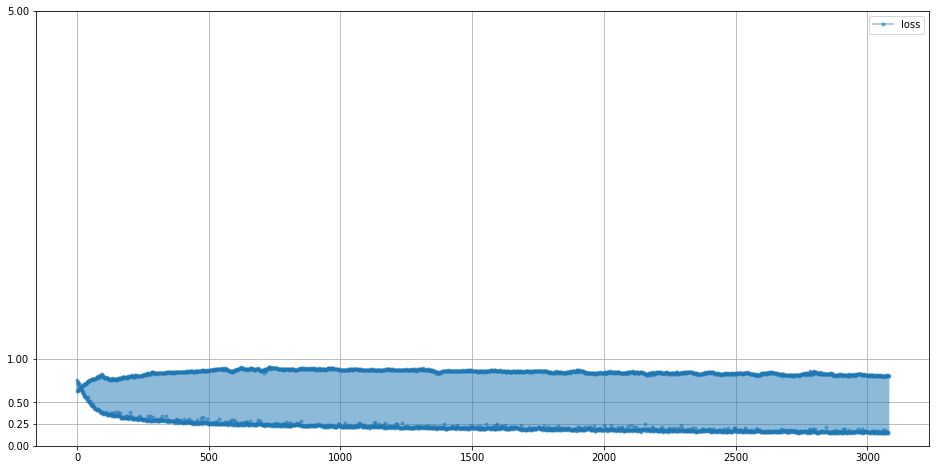

In [41]:
plt_progress(loss_d)

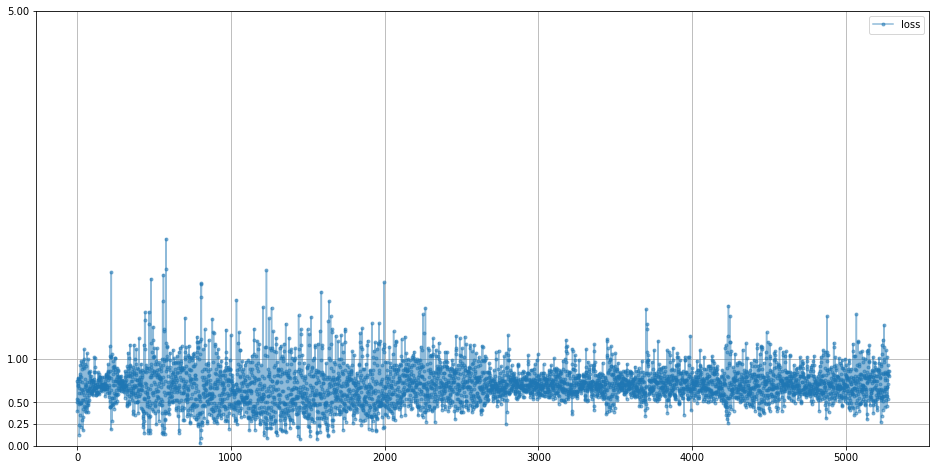

In [26]:
plt_progress(loss_g)

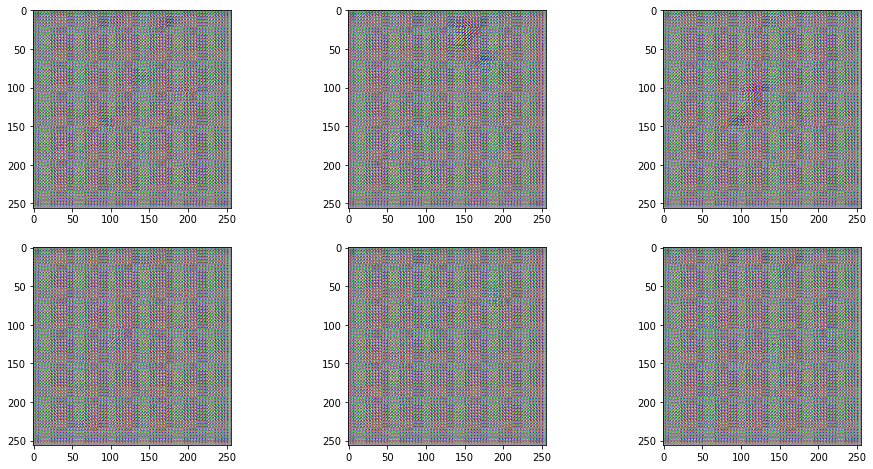

In [30]:
f,ax=plt.subplots(2,3,figsize=(16,8))
for i in range(2):
    for j in range(3):
        output=G.forward()
        img=output.detach().permute(0,2,3,1).view((256,256,3)).cpu().numpy()
        ax[i,j].imshow(img,interpolation='none',cmap='Blues')